What this notebook does:

LDA models with varying numbers of topics are fit to the collection of coffeeshop reviews, where each review is represented by only its lemmatized nouns + adjectives. The lemmatized reviews are found in './ProcessedData/lemmatizedreviews.csv'

Interpretation of topics of the fitted models, based on top words was difficult. I decided not to move forward with using topics defined by nouns + adjectives.

In [ ]:
#Step one directory up to access the yelp scraping function in the helper_functions module
import os
print(os.getcwd())
os.chdir('../')
os.getcwd()

In [2]:
import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim.test.utils import datapath
from gensim import corpora

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

import re

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#For visualizing the LDA topics
import pickle

import pyLDAvis.gensim


import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thomasyoung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
shops = pd.read_csv('./ProcessedData/coffeeshops_withcfcutoff.csv')
reviews = pd.read_csv('./ProcessedData/lemmatizedreviews.csv')
merged = pd.merge(shops,reviews,how='inner',on = ['alias'])


(46077, 12)
(46077, 35)
(791,)
791
46077


In [4]:

data_lemmatized = merged.review_lem_nounadj.str.split(' ')
merged = merged[data_lemmatized.str.len() > 4]
data_lemmatized = merged.review_lem_nounadj.str.split(' ').to_list()



[['nighttime', 'cozy', 'bar', 'vibe', 'vibe', 'price', 'bank', 'weeknight', 'table', 'wait', 'long', 'seat', 'spot', 'date', 'intimate', 'couple', 'friend', 'dinner', 'drink', 'round', 'drink'], ['spritz', 'commissary', 'little', 'canal', 'hip', 'atmosphere', 'less', 'pretense', 'cafe', 'fine', 'way', 'night', 'wine', 'bar', 'selection', 'beer', 'bootleg', 'spritz', 'case', 'spritzer', 'sure', 'usage', 'makeup', 'cappelletti', 'straight', 'flavor', 'wise', 'bootleg', 'bubble', 'gum', 'ish', 'bitter', 'quality', 'taste', 'complex', 'refined', 'comparison', 'perfection', 'little', 'funky', 'drinkable', 'wine', 'range', 'generous', 'server', 'unlimited', 'water', 'self', 'corner', 'quiet', 'chill', 'place', 'crowded', 'small', 'huge', 'crowd', 'price', 'low', 'perfect', 'wine', 'person', 'joint', 'hit', 'step', 'dive', 'step', 'hipster', 'wine', 'bar', 'spot', 'middle', 'ground', 'bonus', 'small', 'place'], ['gallery', 'nearby', 'fantastic', 'beer', 'hummus', 'sandwich', 'day', 'small', '

In [5]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]]
44229
44229
44229
17124
Dictionary(17124 unique tokens: ['canal', 'catch', 'cozy', 'first', 'friend']...)
44229


Since hyperparameter tuning is kind of slow, just try to tune the number of topics rather than the alpha beta parameters.

In [8]:
# Build LDA model with 3 to 9 topics
ldamodlist = []
docldalist = []
cohereldalist = []
for nt in range(5,6):
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=nt, alpha='auto',eta='auto',
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)
    print(f'Number of topics is:{nt}')
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    ldamodlist.append(lda_model)
    docldalist.append(doc_lda)
    cohereldalist.append(coherence_lda)
    


Number of topics is:5
[(0,
  '0.074*"place" + 0.024*"spot" + 0.024*"little" + 0.022*"work" + '
  '0.022*"small" + 0.018*"table" + 0.017*"tea" + 0.015*"space" + '
  '0.014*"friend" + 0.014*"lot"'),
 (1,
  '0.049*"time" + 0.039*"service" + 0.026*"customer" + 0.020*"barista" + '
  '0.020*"morning" + 0.017*"bad" + 0.017*"way" + 0.015*"day" + 0.014*"thing" + '
  '0.013*"line"'),
 (2,
  '0.146*"coffee" + 0.032*"shop" + 0.031*"friendly" + 0.027*"staff" + '
  '0.025*"pastry" + 0.024*"latte" + 0.018*"good" + 0.017*"neighborhood" + '
  '0.017*"milk" + 0.014*"croissant"'),
 (3,
  '0.121*"food" + 0.054*"sandwich" + 0.044*"breakfast" + 0.042*"fresh" + '
  '0.035*"bagel" + 0.027*"cheese" + 0.023*"bread" + 0.021*"item" + 0.021*"egg" '
  '+ 0.019*"salad"'),
 (4,
  '0.030*"today" + 0.020*"close" + 0.019*"home" + 0.018*"product" + '
  '0.017*"terrible" + 0.016*"sugar" + 0.015*"slow" + 0.014*"french" + '
  '0.014*"problem" + 0.014*"standard"')]


[0.4917865646336571]


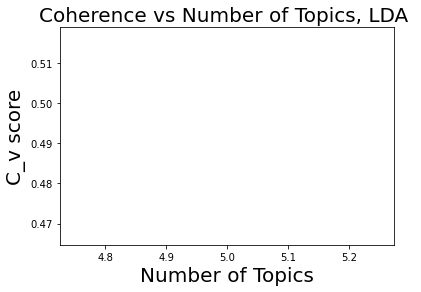

In [10]:
print(cohereldalist)

fig, ax = plt.subplots()
sns.lineplot(x=range(5,6),y=cohereldalist,ax=ax)
ax.set_xlabel('Number of Topics',fontsize=20)
ax.set_ylabel('C_v score',fontsize=20)
ax.set_title('Coherence vs Number of Topics, LDA ',fontsize=20)
fig.savefig('./Figures/LDA/C_v_vs_topics.png',bbox_inches='tight')

#The coherence is highest when there are 5 clusters (0.51)

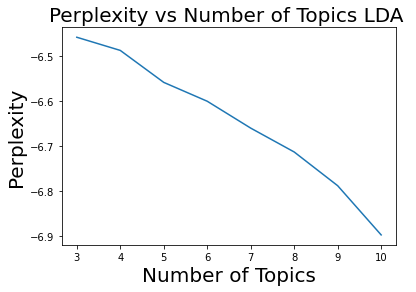

In [14]:
perplexitylist = []
for i in range(len(ldamodlist)):
    perplexitylist.append(ldamodlist[i].log_perplexity(corpus))

fig, ax = plt.subplots()
sns.lineplot(x=range(3,11),y=perplexitylist,ax=ax)
ax.set_xlabel('Number of Topics',fontsize=20)
ax.set_ylabel('Perplexity',fontsize=20)
ax.set_title('Perplexity vs Number of Topics LDA ',fontsize=20)
fig.savefig('./Figures/LDA/logperplexity_vs_topics.png',bbox_inches='tight')



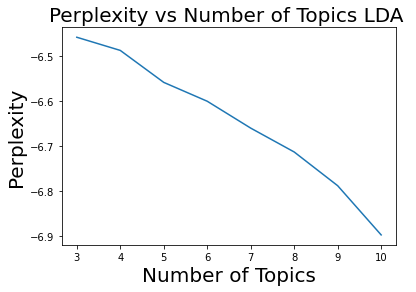

In [16]:
fig, ax = plt.subplots()
sns.lineplot(x=range(3,11),y=perplexitylist,ax=ax)
ax.set_xlabel('Number of Topics',fontsize=20)
ax.set_ylabel('Perplexity',fontsize=20)
ax.set_title('Perplexity vs Number of Topics LDA ',fontsize=20)
fig.savefig('./Figures/LDA/logperplexity_vs_topics.png',bbox_inches='tight')


The coherence score is a little higher when 6 topics are used. 0.52 instead of 0.41